In [1]:
# Imports
import numpy as np
# from google.colab import drive
import os
import os.path as path
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from scipy.io import wavfile # reading .wav files
from zipfile import ZipFile # open archive.zip

np.set_printoptions(precision=4,suppress=True)
# drive.mount('/content/drive')

CUTOFF = 10
BATCH_SIZE = 200

---
# Data Preprocessing Functions

In [2]:
def first_half(array):
    return array[:(len(array)//2)]

In [3]:
def calc_cepstrum(signal, cutoff, use_log):
    ft = np.abs(first_half(np.fft.rfft(signal)))
    #ft = np.abs(np.fft.rfft(first_half(signal)))
    if use_log == True:
        ft = np.log(ft)
    ft -= np.mean(ft, axis = 0) # Remove DC offset.

    cpst = np.abs(np.fft.rfft(ft))[1:cutoff+1]
    if use_log == True:
        cpst = np.log(cpst)

    return (cpst - np.mean(cpst)) / np.std(cpst)

---
# Load and Process Data

In [4]:
zf = ZipFile('/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted/archive.zip', 'r')

In [5]:
def load_sample(zf, speaker, num, example):
    # Bounds check.
    assert(speaker > 0 and speaker < 61 and num < 10 and example < 50)

    speaker_num = str(speaker).rjust(2, '0')
    name = path.join("data", speaker_num, str(num) + '_' + speaker_num + '_' + str(example) + ".wav")
    #samplerate, data = wavfile.read(zf.open('data/01/0_01_0.wav'))
    samplerate, data = wavfile.read(zf.open(name))

    return data

In [6]:
def get_mini_batch(size):
    # Get random examples.
    speaker_mini = np.random.randint(1, 61, size)
    num_mini = np.random.randint(0, 10, size)
    example_mini = np.random.randint(0, 50, size)

    data = []
    for i in range(size):
        data.append(load_sample(zf, speaker_mini[i], num_mini[i], example_mini[i]))
        #labels.vstack([speaker_mini[i], num_mini[i], example_mini[i]])

    labels = np.vstack((speaker_mini, num_mini, example_mini)).T[:, 1]
    return data, labels

In [7]:
def process_batch(data, cutoff, use_log):
    new_data = np.zeros((len(data), cutoff))
    for i in range(len(data)):
        new_data[i] = calc_cepstrum(data[i], cutoff, use_log)

    return new_data

In [8]:
# Only needs to be run once! Applies the data preprocessing to entire dataset.
"""
cepstrums = []
labels = []
for file in zf.namelist():
    try:
        label = file.split("_")
        label[0] = int(label[0][-1])
        label[1] = int(label[1])
        label[2] = int(label[2][:-4])
        labels.append(label)

        samplerate, data = wavfile.read(zf.open(file))
        cepstrums.append(calc_cepstrum(data, 10, False))
    except:
        print(file)
        pass

np.savez_compressed("drive/Shareddrives/CS539 Project/work/features", cepstrums, delimiter = ",")
np.savez_compressed("drive/Shareddrives/CS539 Project/work/labels", labels, delimiter = ",")
"""

'\ncepstrums = []\nlabels = []\nfor file in zf.namelist():\n    try:\n        label = file.split("_")\n        label[0] = int(label[0][-1])\n        label[1] = int(label[1])\n        label[2] = int(label[2][:-4])\n        labels.append(label)\n\n        samplerate, data = wavfile.read(zf.open(file))\n        cepstrums.append(calc_cepstrum(data, 10, False))\n    except:\n        print(file)\n        pass\n\nnp.savez_compressed("drive/Shareddrives/CS539 Project/work/features", cepstrums, delimiter = ",")\nnp.savez_compressed("drive/Shareddrives/CS539 Project/work/labels", labels, delimiter = ",")\n'

In [9]:
def get_preprocessed_data():
    data = np.load("/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted/features.npz")['arr_0']
    labels = np.load("/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/handcrafted/labels.npz")['arr_0'][:, 0]

    data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size = 0.1)
    return data_train, data_val, labels_train, labels_val

---
# Try it out/View Data

In [10]:
wav, labels = get_mini_batch(BATCH_SIZE)
data = process_batch(wav, CUTOFF, False)

data_train, data_val, label_train, label_val = train_test_split(data, labels, test_size = 0.1)

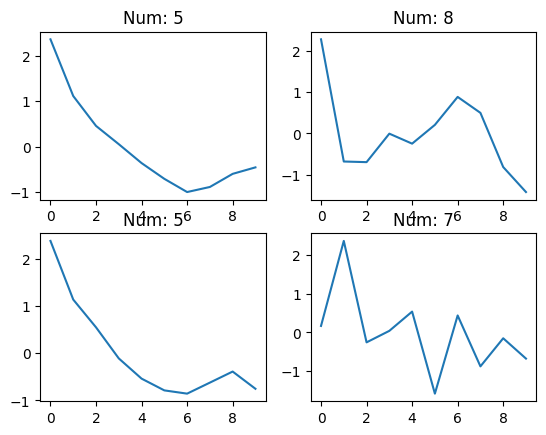

In [11]:
w = 2
h = 2
indices = np.random.randint(0, len(data_train), w * h)
fig, axs = plt.subplots(h, w)
for i in range(h):
    for j in range(w):
        axs[i, j].plot(data_train[indices[i*h + j]])
        ttl = "Num: " + str(label_train[indices[i*h + j]])
        axs[i, j].set_title(ttl)

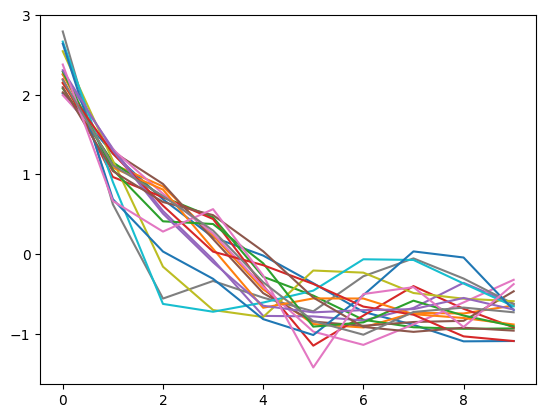

In [12]:
for i in range(len(label_train)):
    if label_train[i] == 9:
        plt.plot(data_train[i])

In [13]:
# Calculate mean curves for each number.

mean_curves = np.zeros([10, CUTOFF])
nums = np.zeros(10)

for i in range(len(label_train)):
    num = label_train[i]
    nums[num] += 1
    mean_curves[num] += data_train[num]
mean_curves /= nums

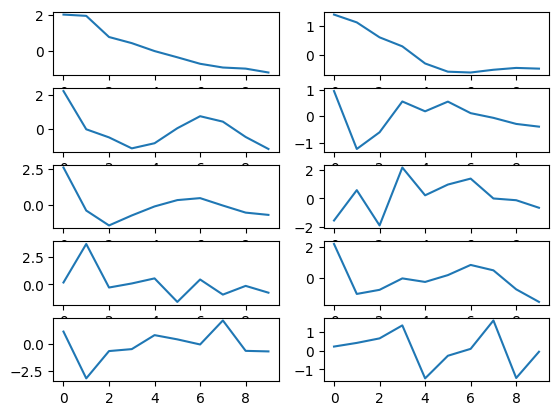

In [14]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(mean_curves[i])

---
## KNN with all sample features

In [15]:
# DEPRECATED: SVD computes all singular values when we only need first N.
# Direct PCA implementation is much faster and memory efficient.
"""
centered_data = data_train - np.mean(data_train, axis = 0)
U, S, Vh = np.linalg.svd(centered_data)

Vr = Vh.T[:, :7]
features = centered_data @ Vr
val_features = (data_val - np.mean(data_val, axis = 0)) @ Vr
"""

'\ncentered_data = data_train - np.mean(data_train, axis = 0)\nU, S, Vh = np.linalg.svd(centered_data)\n\nVr = Vh.T[:, :7]\nfeatures = centered_data @ Vr\nval_features = (data_val - np.mean(data_val, axis = 0)) @ Vr\n'

---
# Finish Preprocessing + Evaluation

In [16]:
data_train, data_val, label_train, label_val = get_preprocessed_data()

In [17]:
from sklearn.decomposition import PCA
import time

N_COMPONENTS = 9
df_pca = PCA(n_components = N_COMPONENTS)
df_pca.fit(data_train)
features = df_pca.transform(data_train)

nn = NearestNeighbors(n_neighbors = 1, leaf_size = 1000).fit(features)

def inference(data, preprocess = True):
    t0 = time.process_time()
    if preprocess:
        data_processed = process_batch(data, CUTOFF, False)
    else:
        data_processed = data

    t1 = time.process_time()

    data_pca = df_pca.transform(data_processed)
    distances, indices = nn.kneighbors(data_pca)
    t2 = time.process_time()

    return (t1 - t0), (t2 - t1), label_train[indices]

In [18]:
wav, labels = get_mini_batch(len(label_val))

In [19]:
# MEASURING SPEED.
preprocess_time, inference_time, indices = inference(wav, preprocess = True)

avg_time = (inference_time + preprocess_time) / len(data_val)
print("Average time per sample: ", avg_time)
ratio = preprocess_time / (inference_time + preprocess_time)
print("Ratio of preprocessing time to total time:", ratio)

Average time per sample:  0.0018350289999999993
Ratio of preprocessing time to total time: 0.9367657586519526


In [20]:
# MEASURING ACCURACY
_, _, indices = inference(data_val, False)

from sklearn.metrics import confusion_matrix

ypred = indices
ytrue = label_val.reshape(-1, 1)

print(confusion_matrix(ytrue, ypred))

correct = (ypred == ytrue)
val_acc = np.sum(correct) / len(correct)
print("Validation accuracy:", val_acc)

[[141   2  19  28   7  10  19  43  10  13]
 [  0 232   2   0  30  22   0   2   0  24]
 [ 14   4 183  16   7   8  16  17   8  10]
 [ 19   0   9 169   1   4   5   2  43   7]
 [  0  51   3   2 251  23   0   1   0   5]
 [  6  39   4   0  21 217   0   1   0  31]
 [ 10   0  18  10   0   0 217  22  19   0]
 [ 48   1  11   6   2   2  25 192   2   7]
 [  7   0   3  38   0   0   6   1 264   0]
 [  8  16   4   6   5  32   0   2   0 215]]
Validation accuracy: 0.6936666666666667


---
# Visualize Feature Points

In [21]:
N_COMPONENTS = 3
df_pca = PCA(n_components = N_COMPONENTS)
df_pca.fit(data_train)
reduced_features = df_pca.transform(data_train)

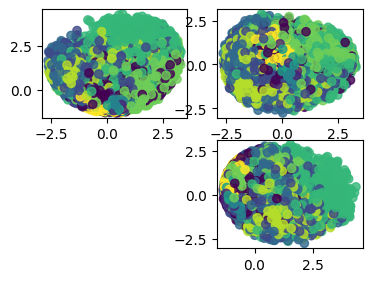

In [22]:
for i in range(N_COMPONENTS):
    for j in range(i + 1, N_COMPONENTS):
        plt.subplot(N_COMPONENTS, N_COMPONENTS, i * N_COMPONENTS + j + 1)
        #plt.title(str(i) + ", " + str(j))
        plt.scatter(reduced_features[:, i], reduced_features[:, j], c = label_train, alpha = 0.8)